**Concept Drift MLaaS Context**
---

In [1]:
import numpy as np
import time
import tensorflow as tf
import json
import os
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

# Global Configuration
CONFIG = {
    "num_clients": 5,
    "num_rounds": 10,  # Set to 10 rounds
    "local_epochs": 5,  # Set to 5 epochs
    "batch_size": 32,
    "learning_rate": 0.01,
    "reduced_neurons": 64  # Reduced the number of neurons in dense layers
}

# Clients with moderate noise
NOISE_CLIENTS = [1, 2, 3]  # Clients with moderate noise
NOISE_FACTOR = 0.5  # Moderate noise level

# Clients with high noise
HIGH_NOISE_CLIENTS = [0, 4]  # Specify multiple clients with severe noise
HIGH_NOISE_FACTOR = 3.0  # Extreme noise level

# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

# Split the data among clients with noise for concept drift
def split_data(x, y, num_clients, noise_clients, noise_factor, high_noise_clients, high_noise_factor):
    x, y = shuffle(x, y, random_state=42)  # Shuffle before splitting
    data_per_client = len(x) // num_clients
    clients_data = []

    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client
        x_client, y_client = x[start:end], y[start:end]

        if i in noise_clients:
            noise = np.random.normal(loc=0.0, scale=noise_factor, size=x_client.shape)
            x_client = np.clip(x_client + noise, 0.0, 1.0)

        if i in high_noise_clients:
            noise = np.random.normal(loc=0.0, scale=high_noise_factor, size=x_client.shape)
            x_client = np.clip(x_client + noise, 0.0, 1.0)

        clients_data.append((x_client, y_client))

    return clients_data

# Apply data split with noise
clients_data = split_data(x_train, y_train, CONFIG["num_clients"], NOISE_CLIENTS, NOISE_FACTOR, HIGH_NOISE_CLIENTS, HIGH_NOISE_FACTOR)

# Define the Model
def create_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(CONFIG["reduced_neurons"], activation='relu'),  # Reduced neurons
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=CONFIG["learning_rate"]),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train Local Model on Each Client & Evaluate Accuracy
def train_local_model(model, x, y, epochs, batch_size):
    model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=0)
    loss, accuracy = model.evaluate(x, y, verbose=0)
    return model.get_weights(), accuracy

# Aggregate Weights on the Server
def aggregate_weights(client_weights):
    return [np.mean(w, axis=0) for w in zip(*client_weights)]

# Evaluate the Global Model
def evaluate_global_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy

# Save weights to separate JSON files
def save_weights_to_json(round_num, client_id, client_weights, is_global=False):
    folder = "federated_weights"
    os.makedirs(folder, exist_ok=True)

    file_name = f"{folder}/global_round_{round_num}.json" if is_global else f"{folder}/client_{client_id}_round_{round_num}.json"

    weights_dict = {
        "round": round_num,
        "weights": [w.tolist() for w in client_weights]
    }

    with open(file_name, "w") as f:
        json.dump(weights_dict, f, indent=4)

# Federated Learning Process
global_model = create_model()
round_times = []  # Store computation time for each round

for round_num in range(CONFIG["num_rounds"]):
    start_time = time.time()
    print(f"\n--- Round {round_num + 1} ---")

    client_accuracies = []
    client_weights = []

    for client_id, (x_client, y_client) in enumerate(clients_data):
        print(f"\nClient {client_id + 1} training...")
        local_model = create_model()
        local_model.set_weights(global_model.get_weights())
        new_weights, accuracy = train_local_model(local_model, x_client, y_client, CONFIG["local_epochs"], CONFIG["batch_size"])

        client_weights.append(new_weights)
        client_accuracies.append((client_id + 1, accuracy))

        save_weights_to_json(round_num + 1, client_id + 1, new_weights, is_global=False)

    print("\n📌 Local Client Accuracies after Round", round_num + 1)
    for client_id, acc in client_accuracies:
        print(f"   → Client {client_id} Accuracy: {acc:.4f}")

    print("\nAggregating client weights...")
    new_global_weights = aggregate_weights(client_weights)
    global_model.set_weights(new_global_weights)

    save_weights_to_json(round_num + 1, 0, new_global_weights, is_global=True)

    global_accuracy = evaluate_global_model(global_model, x_test, y_test)
    print(f"\n🌍 Global Model Accuracy after Round {round_num + 1}: {global_accuracy:.4f}")

    end_time = time.time()
    round_time = end_time - start_time
    round_times.append(round_time)  # Store round computation time

print("\n✅ Federated Learning Process Complete!")

# Save round computation times
round_time_file = "round_computation_times.json"
with open(round_time_file, "w") as f:
    json.dump({"round_times": round_times}, f, indent=4)

# Display computation times
print("\n⏳ Round Computation Times:", round_times)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Round 1 ---

Client 1 training...

Client 2 training...

Client 3 training...

Client 4 training...

Client 5 training...

📌 Local Client Accuracies after Round 1
   → Client 1 Accuracy: 0.2073
   → Client 2 Accuracy: 0.8508
   → Client 3 Accuracy: 0.8473
   → Client 4 Accuracy: 0.8497
   → Client 5 Accuracy: 0.2382

Aggregating client weights...

🌍 Global Model Accuracy after Round 1: 0.8537

--- Round 2 ---

Client 1 training...

Client 2 training...

Client 3 training...

Client 4 training...

Client 5 training...

📌 Local Client Accuracies after Round 2
   → Client 1 Accuracy: 0.3257
   → Client 2 Accuracy: 0.8713
   → Client 3 Accuracy: 0.8719
   → Client 4 Accuracy: 0.8737
   → Client 5 Accuracy: 0.3220

Aggregating client weights...

🌍 Global Model Accuracy after Round 2: 0.8743

--- Round 3 ---

Client 1 training...

Client 2 training...

Client 3 training...

Client 4 training...

Client 5 training...

📌 Local Client Accuracies after Round 3
   → Client 1 Accuracy: 0.3273

**Functional Contribution Score**
---

In [2]:
import json
import numpy as np
import os
import time
import pandas as pd

begin = time.time()

# Paths for global model and client weight files
num_clients = 5  # Number of clients
num_rounds = 10  # Number of rounds

# Initialize list to store computation time for each round
round_times = []

def recursively_flatten(weights):
    flat_list = []
    if isinstance(weights, dict):
        for key in weights:
            flat_list.extend(recursively_flatten(weights[key]))
    elif isinstance(weights, list):
        for item in weights:
            flat_list.extend(recursively_flatten(item))
    else:
        flat_list.append(weights)
    return flat_list

# Store client contributions across rounds
all_round_contributions = {}
contributions_list = []  # For DataFrame

for round_num in range(1, num_rounds + 1):
    round_start = time.time()

    global_weights_path = f"/content/federated_weights/global_round_{round_num}.json"

    if not os.path.exists(global_weights_path):
        print(f"Global model file not found: {global_weights_path}")
        continue

    with open(global_weights_path, "r") as f:
        global_weights = json.load(f)

    global_flattened = np.array(recursively_flatten(global_weights))

    client_contributions = {}

    for client_id in range(1, num_clients + 1):
        client_file = f"/content/federated_weights/client_{client_id}_round_{round_num}.json"

        if not os.path.exists(client_file):
            print(f"File not found: {client_file}")
            continue

        with open(client_file, "r") as f:
            client_weights_data = json.load(f)
            client_weights = client_weights_data["weights"]

        client_flattened = np.array(recursively_flatten(client_weights))

        min_length = min(len(global_flattened), len(client_flattened))
        global_flattened_adj = global_flattened[:min_length]
        client_flattened_adj = client_flattened[:min_length]

        local_update = client_flattened_adj - global_flattened_adj
        distance_local_global = np.linalg.norm(local_update)
        g_p_k = 1 / distance_local_global if distance_local_global != 0 else 0

        client_contributions[client_id] = {
            "distance": distance_local_global,
            "g_p_k": g_p_k
        }

    total_weighted_distance = sum(client["g_p_k"] * client["distance"] for client in client_contributions.values())

    for client_id in client_contributions:
        g_p_k = client_contributions[client_id]["g_p_k"]
        distance_local_global = client_contributions[client_id]["distance"]

        if total_weighted_distance == 0:
            contribution_value = 0
        else:
            contribution_value = (g_p_k * distance_local_global) / total_weighted_distance

        client_contributions[client_id]["contribution"] = contribution_value
        contributions_list.append({
            "Round": round_num,
            "Client": client_id,
            "Contribution": contribution_value
        })

    all_round_contributions[round_num] = client_contributions

    round_end = time.time()
    round_times.append(round_end - round_start)  # Store round computation time

# Create DataFrame to summarize contributions
df_contributions = pd.DataFrame(contributions_list)
df_contributions = df_contributions.pivot(index="Client", columns="Round", values="Contribution").fillna(0)
df_contributions["Total Contribution"] = df_contributions.sum(axis=1)

end = time.time()
NCS = end - begin
print(NCS)

print("\n📌 Round-wise Client Contributions:")
print(df_contributions)

df_contributions.to_csv("client_contributions_summary.csv", index=True)

# Save round computation times
round_time_file = "round_computation_times.json"
with open(round_time_file, "w") as f:
    json.dump({"round_times": round_times}, f, indent=4)

print("\n⏳ Round Computation Times:", round_times)

12.977109432220459

📌 Round-wise Client Contributions:
Round     1    2    3    4    5    6    7    8    9   10  Total Contribution
Client                                                                      
1       0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2                 2.0
2       0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2                 2.0
3       0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2                 2.0
4       0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2                 2.0
5       0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2                 2.0

⏳ Round Computation Times: [1.1997272968292236, 1.2365427017211914, 1.1820976734161377, 1.1952683925628662, 1.2120616436004639, 1.19217848777771, 1.1919035911560059, 1.1998977661132812, 1.5323870182037354, 1.7833738327026367]


**SHAP(BaseLine)**
---

In [29]:
import itertools
import numpy as np
import time
import tensorflow as tf
import json
import os
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

# Global Configuration
CONFIG = {
    "num_clients": 5,
    "num_rounds": 1,  # Single round for SHARP computation
    "local_epochs": 1,
    "batch_size": 32,
    "learning_rate": 0.01,
    "reduced_neurons": 64  # Keep consistency with the base model
}

# Clients with moderate noise
NOISE_CLIENTS = [1, 2, 3]
NOISE_FACTOR = 0.5

# Clients with high noise
HIGH_NOISE_CLIENTS = [0, 4]
HIGH_NOISE_FACTOR = 3.0

# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Split the data among clients with noise for concept drift
def split_data(x, y, num_clients, noise_clients, noise_factor, high_noise_clients, high_noise_factor):
    x, y = shuffle(x, y, random_state=42)
    data_per_client = len(x) // num_clients
    clients_data = []

    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client
        x_client, y_client = x[start:end], y[start:end]

        if i in noise_clients:
            noise = np.random.normal(loc=0.0, scale=noise_factor, size=x_client.shape)
            x_client = np.clip(x_client + noise, 0.0, 1.0)

        if i in high_noise_clients:
            noise = np.random.normal(loc=0.0, scale=high_noise_factor, size=x_client.shape)
            x_client = np.clip(x_client + noise, 0.0, 1.0)

        clients_data.append((x_client, y_client))

    return clients_data

# Apply data split with noise
clients_data = split_data(x_train, y_train, CONFIG["num_clients"], NOISE_CLIENTS, NOISE_FACTOR, HIGH_NOISE_CLIENTS, HIGH_NOISE_FACTOR)

# Define the Model
def create_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(CONFIG["reduced_neurons"], activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=CONFIG["learning_rate"]),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train a model on a subset of clients
def train_subset_model(subset):
    model = create_model()
    for client_id in subset:
        x_client, y_client = clients_data[client_id]
        model.fit(x_client, y_client, epochs=CONFIG["local_epochs"], batch_size=CONFIG["batch_size"], verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy

# Compute SHARP Values
def compute_sharp_values(num_clients):
    client_contributions = {i: [] for i in range(num_clients)}
    all_clients = list(range(num_clients))

    for subset_size in range(1, num_clients + 1):
        for subset in itertools.combinations(all_clients, subset_size):
            subset = list(subset)
            subset_accuracy = train_subset_model(subset)

            for client in subset:
                without_client = subset.copy()
                without_client.remove(client)
                without_client_accuracy = train_subset_model(without_client) if without_client else 0

                marginal_contribution = subset_accuracy - without_client_accuracy
                client_contributions[client].append(marginal_contribution)

    sharp_values = {client: np.mean(contributions) for client, contributions in client_contributions.items()}
    return sharp_values

# Run SHARP Calculation
start_time = time.time()
sharp_values = compute_sharp_values(CONFIG["num_clients"])
end_time = time.time()

# Print SHARP Values
print("\n📌 SHARP Values for Client Contributions:")
for client, value in sharp_values.items():
    print(f"   → Client {client + 1}: {value:.4f}")

# Save SHARP values
sharp_file = "sharp_values.json"
with open(sharp_file, "w") as f:
    json.dump({"sharp_values": sharp_values, "computation_time": end_time - start_time}, f, indent=4)

print(f"\n⏳ SHARP Computation Time: {end_time - start_time:.2f} seconds")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📌 SHARP Values for Client Contributions:
   → Client 1: -0.0038
   → Client 2: 0.1593
   → Client 3: 0.1633
   → Client 4: 0.1540
   → Client 5: -0.0206

⏳ SHARP Computation Time: 1624.99 seconds


In [ ]:
import itertools
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

# Global Configuration
NUM_CLIENTS = 5  # You can change this number
NUM_ROUNDS = 1
LOCAL_EPOCHS = 1
BATCH_SIZE = 32
LEARNING_RATE = 0.01
begin = time.time()
# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Split the dataset into equal parts for clients
def split_data(x, y, num_clients):
    x, y = shuffle(x, y, random_state=42)
    data_per_client = len(x) // num_clients
    clients_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client
        clients_data.append((x[start:end], y[start:end]))
    return clients_data

clients_data = split_data(x_train, y_train, NUM_CLIENTS)

# Define the Model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train Model on Subset of Clients
def train_subset_model(subset):
    model = create_model()
    for client_id in subset:
        x_client, y_client = clients_data[client_id]
        model.fit(x_client, y_client, epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)  # Evaluate on global test set
    return accuracy

# Compute Shapley Values
def compute_shapley_values(num_clients):
    client_contributions = {i: [] for i in range(num_clients)}
    all_clients = list(range(num_clients))
    for subset_size in range(1, num_clients + 1):
        for subset in itertools.combinations(all_clients, subset_size):
            subset = list(subset)
            subset_accuracy = train_subset_model(subset)

            for client in subset:
                without_client = subset.copy()
                without_client.remove(client)
                without_client_accuracy = train_subset_model(without_client) if without_client else 0

                marginal_contribution = subset_accuracy - without_client_accuracy
                client_contributions[client].append(marginal_contribution)

    shapley_values = {client: np.mean(contributions) for client, contributions in client_contributions.items()}
    return shapley_values

# Run Shapley Value Calculation
shapley_values = compute_shapley_values(NUM_CLIENTS)
end=time.time()
shapley_time= begin-end
print(shapley_time)
# Print Shapley Values
print("\n📌 Shapley Values for Client Contributions:")
for client, value in shapley_values.items():
    print(f"   → Client {client + 1}: {value:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


-2379.2615678310394

📌 Shapley Values for Client Contributions:
   → Client 1: 0.0675
   → Client 2: 0.0667
   → Client 3: 0.0681
   → Client 4: 0.0641
   → Client 5: 0.0655


**Leave One Out(QoS Updated)**
---

In [17]:
import numpy as np
import time
import tensorflow as tf
import json
import os
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

begin = time.time()

# Global Configuration
NUM_CLIENTS = 5
NUM_ROUNDS = 2
LOCAL_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01

# Clients with moderate noise
NOISE_CLIENTS = [1, 2, 3]
NOISE_FACTOR = 0.5

# Clients with high noise
HIGH_NOISE_CLIENTS = [0, 4]
HIGH_NOISE_FACTOR = 3.0

# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Split Data
clients_data = []
data_per_client = len(x_train) // NUM_CLIENTS
x_train, y_train = shuffle(x_train, y_train, random_state=42)

for i in range(NUM_CLIENTS):
    start, end = i * data_per_client, (i + 1) * data_per_client
    x_client, y_client = x_train[start:end], y_train[start:end]
    noise_factor = NOISE_FACTOR if i in NOISE_CLIENTS else HIGH_NOISE_FACTOR if i in HIGH_NOISE_CLIENTS else 0
    x_client = np.clip(x_client + np.random.normal(0.0, noise_factor, x_client.shape), 0.0, 1.0)
    clients_data.append((x_client, y_client))

def create_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(CONFIG["reduced_neurons"], activation='relu'),  # Using config-defined neurons
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=CONFIG["learning_rate"]),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_local_model(model, x, y, epochs, batch_size):
    start_time = time.time()
    model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=0)
    loss, accuracy = model.evaluate(x, y, verbose=0)
    return model.get_weights(), accuracy, time.time() - start_time

def compute_loo_contributions():
    results = []

    for round_num in range(NUM_ROUNDS):
        round_start_time = time.time()

        full_acc, full_quality, full_time = train_full_model()
        accuracies_list, quality_list = [], []

        for client_id in range(NUM_CLIENTS):
            acc_without_client, quality_without_client, _ = train_loo_model(client_id)
            acc_contribution = full_acc - acc_without_client
            qual_contribution = full_quality - quality_without_client
            accuracies_list.append(acc_contribution)
            quality_list.append(qual_contribution)

        def normalize(values):
            min_val, max_val = min(values), max(values)
            return [(v - min_val) / (max_val - min_val) if max_val - min_val > 0 else 0 for v in values]

        norm_accuracies = normalize(accuracies_list)
        norm_quality = normalize(quality_list)

        final_contributions = {
            client: (norm_accuracies[client] + norm_quality[client]) / 2  # Removed unnecessary time normalization
            for client in range(NUM_CLIENTS)
        }

        round_end_time = time.time()
        round_time = round_end_time - round_start_time

        results.append({
            "round": round_num + 1,
            "contributions": final_contributions,
            "computation_time": round_time
        })

        # Save intermediate results after each round
        with open("loo_contributions.json", "w") as f:
            json.dump(results, f, indent=4)

    return results

# Run LOO Contribution Calculation
loo_contributions = compute_loo_contributions()

# Print Results
print("\n📌 Leave-One-Out (LOO) Contributions per Round:")
for round_data in loo_contributions:
    print(f"Round {round_data['round']}:")
    for client, value in round_data['contributions'].items():
        print(f"   → Client {client + 1}: {value:.4f}")
    print(f"   → Computation Time: {round_data['computation_time']:.2f} seconds")

end = time.time()
print(f"Total execution time: {end - begin:.2f} seconds")
#loo_contributions.to_csV("LLO_2.csv")


📌 Leave-One-Out (LOO) Contributions per Round:
Round 1:
   → Client 1: 0.0800
   → Client 2: 0.7941
   → Client 3: 1.0000
   → Client 4: 0.8576
   → Client 5: 0.0000
   → Computation Time: 779.43 seconds
Round 2:
   → Client 1: 0.1330
   → Client 2: 0.5938
   → Client 3: 1.0000
   → Client 4: 0.9198
   → Client 5: 0.0000
   → Computation Time: 774.15 seconds
Total execution time: 1556.43 seconds


In [20]:
df=pd.read_csv("/content/LOO_2.csv")
df

,Unnamed: 0,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,Round 10
0,Client 1,-0.2916,0.0251,0.0800,0.1330,0.130408,0.127487,0.124213,0.125257,0.124874,0.126840
1,Client 2,0.3505,0.3375,0.7941,0.5938,0.588250,0.585586,0.605379,0.590012,0.582217,0.587489
2,Client 3,0.3978,0.3126,1.0000,1.0000,1.000000,1.000000,1.000000,1.000000,0.961678,0.985476
3,Client 4,0.6667,0.5696,0.8576,0.9198,0.928214,0.973508,0.938265,0.939013,0.911105,0.917611
4,Client 5,-0.0957,-0.2001,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000


In [18]:
import numpy as np
import time
import tensorflow as tf
import json
import os
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle
begin=time.time()
# Global Configuration
NUM_CLIENTS = 5
NUM_ROUNDS = 1
LOCAL_EPOCHS = 2
BATCH_SIZE = 32
LEARNING_RATE = 0.01

# Clients with moderate noise
NOISE_CLIENTS = [1, 2, 3]
NOISE_FACTOR = 0.5

# Clients with high noise
HIGH_NOISE_CLIENTS = [0, 4]
HIGH_NOISE_FACTOR = 3.0

# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Split Data
clients_data = []
data_per_client = len(x_train) // NUM_CLIENTS
x_train, y_train = shuffle(x_train, y_train, random_state=42)

for i in range(NUM_CLIENTS):
    start, end = i * data_per_client, (i + 1) * data_per_client
    x_client, y_client = x_train[start:end], y_train[start:end]
    noise_factor = NOISE_FACTOR if i in NOISE_CLIENTS else HIGH_NOISE_FACTOR if i in HIGH_NOISE_CLIENTS else 0
    x_client = np.clip(x_client + np.random.normal(0.0, noise_factor, x_client.shape), 0.0, 1.0)
    clients_data.append((x_client, y_client))

def create_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(CONFIG["reduced_neurons"], activation='relu'),  # Reduced neurons
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=CONFIG["learning_rate"]),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train Local Model
def train_local_model(model, x, y, epochs, batch_size):
    start_time = time.time()
    model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=0)
    loss, accuracy = model.evaluate(x, y, verbose=0)
    return model.get_weights(), accuracy, time.time() - start_time

# Aggregate Weights
def aggregate_weights(client_weights):
    return [np.mean(w, axis=0) for w in zip(*client_weights)]

# Evaluate Global Model
def evaluate_global_model(model, x_test, y_test):
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy

# Train Full Model
def train_full_model():
    global_model = create_model()
    client_weights, accuracies, times = [], [], []

    for x_client, y_client in clients_data:
        local_model = create_model()
        local_model.set_weights(global_model.get_weights())
        new_weights, acc, comp_time = train_local_model(local_model, x_client, y_client, LOCAL_EPOCHS, BATCH_SIZE)
        client_weights.append(new_weights)
        accuracies.append(acc)
        times.append(comp_time)

    global_weights = aggregate_weights(client_weights)
    global_model.set_weights(global_weights)
    return evaluate_global_model(global_model, x_test, y_test), np.mean(accuracies), np.array(times)

# Train Leave-One-Out Model
def train_loo_model(excluded_client):
    global_model = create_model()
    client_weights, accuracies, times = [], [], []

    for client_id, (x_client, y_client) in enumerate(clients_data):
        if client_id == excluded_client:
            continue
        local_model = create_model()
        local_model.set_weights(global_model.get_weights())
        new_weights, acc, comp_time = train_local_model(local_model, x_client, y_client, LOCAL_EPOCHS, BATCH_SIZE)
        client_weights.append(new_weights)
        accuracies.append(acc)
        times.append(comp_time)

    global_weights = aggregate_weights(client_weights)
    global_model.set_weights(global_weights)
    return evaluate_global_model(global_model, x_test, y_test), np.mean(accuracies), np.array(times)

# Compute Leave-One-Out Contributions
def compute_loo_contributions():
    full_acc, full_quality, full_times = train_full_model()
    client_contributions = {}
    times_list, accuracies_list, quality_list = [], [], []

    for client_id in range(NUM_CLIENTS):
        acc_without_client, quality_without_client, times_without_client = train_loo_model(client_id)
        acc_contribution = full_acc - acc_without_client
        qual_contribution = full_quality - quality_without_client
        time_contribution = full_times[client_id] - np.mean(times_without_client)
        accuracies_list.append(acc_contribution)
        quality_list.append(qual_contribution)
        times_list.append(time_contribution)

    # Normalize values (scaling to 0-1)
    def normalize(values):
        min_val, max_val = min(values), max(values)
        return [(v - min_val) / (max_val - min_val) if max_val - min_val > 0 else 0 for v in values]

    norm_accuracies = normalize(accuracies_list)
    norm_quality = normalize(quality_list)
    norm_times = normalize(times_list)

    # Compute final contribution scores (weighted equally)
    final_contributions = {
        client: (norm_accuracies[client] + norm_quality[client] - norm_times[client]) / 3
        for client in range(NUM_CLIENTS)
    }

    return final_contributions


# Run LOO Contribution Calculation
loo_contributions = compute_loo_contributions()

# Print Results
print("\n📌 Leave-One-Out (LOO) Contributions (0-1 scale):")
for client, value in loo_contributions.items():
    print(f"   → Client {client + 1}: {value:.4f}")
end=time.time()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📌 Leave-One-Out (LOO) Contributions (0-1 scale):
   → Client 1: -0.1038
   → Client 2: 0.5140
   → Client 3: 0.5617
   → Client 4: 0.1354
   → Client 5: -0.0105


**Old Code**

In [ ]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

# Global Configuration
NUM_CLIENTS = 5
NUM_ROUNDS = 2  # Adjusted for clarity
LOCAL_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01

# Clients with moderate noise
NOISE_CLIENTS = [1, 2, 3]
NOISE_FACTOR = 0.5

# Clients with high noise
HIGH_NOISE_CLIENTS = [0, 4]
HIGH_NOISE_FACTOR = 3.0

# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Split Data
clients_data = []
data_per_client = len(x_train) // NUM_CLIENTS
x_train, y_train = shuffle(x_train, y_train, random_state=42)

for i in range(NUM_CLIENTS):
    start, end = i * data_per_client, (i + 1) * data_per_client
    x_client, y_client = x_train[start:end], y_train[start:end]
    noise_factor = NOISE_FACTOR if i in NOISE_CLIENTS else HIGH_NOISE_FACTOR if i in HIGH_NOISE_CLIENTS else 0
    x_client = np.clip(x_client + np.random.normal(0.0, noise_factor, x_client.shape), 0.0, 1.0)
    clients_data.append((x_client, y_client))

def create_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_local_model(model, x, y, epochs, batch_size):
    model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=0)
    loss, accuracy = model.evaluate(x, y, verbose=0)
    return model.get_weights(), accuracy

def aggregate_weights(client_weights):
    return [np.mean(w, axis=0) for w in zip(*client_weights)]

def evaluate_global_model(model, x_test, y_test):
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy

def train_full_model():
    global_model = create_model()
    client_weights = []
    accuracies = []

    for x_client, y_client in clients_data:
        local_model = create_model()
        local_model.set_weights(global_model.get_weights())
        new_weights, acc = train_local_model(local_model, x_client, y_client, LOCAL_EPOCHS, BATCH_SIZE)
        client_weights.append(new_weights)
        accuracies.append(acc)

    global_weights = aggregate_weights(client_weights)
    global_model.set_weights(global_weights)
    return evaluate_global_model(global_model, x_test, y_test), np.mean(accuracies)

def train_loo_model(excluded_client):
    global_model = create_model()
    client_weights = []
    accuracies = []

    for client_id, (x_client, y_client) in enumerate(clients_data):
        if client_id == excluded_client:
            continue
        local_model = create_model()
        local_model.set_weights(global_model.get_weights())
        new_weights, acc = train_local_model(local_model, x_client, y_client, LOCAL_EPOCHS, BATCH_SIZE)
        client_weights.append(new_weights)
        accuracies.append(acc)

    global_weights = aggregate_weights(client_weights)
    global_model.set_weights(global_weights)
    return evaluate_global_model(global_model, x_test, y_test), np.mean(accuracies)

def compute_loo_contributions():
    round_times = []
    contributions_per_round = []

    for round_num in range(NUM_ROUNDS):
        start_round_time = time.time()
        full_acc, full_quality = train_full_model()
        round_time = time.time() - start_round_time
        round_times.append(round_time)

        client_contributions = {}
        accuracies_list = []

        for client_id in range(NUM_CLIENTS):
            acc_without_client, quality_without_client = train_loo_model(client_id)
            acc_contribution = full_acc - acc_without_client
            accuracies_list.append(acc_contribution)

        def normalize(values):
            min_val, max_val = min(values), max(values)
            return [(v - min_val) / (max_val - min_val) if max_val - min_val > 0 else 0 for v in values]

        norm_accuracies = normalize(accuracies_list)
        final_contributions = {client: norm_accuracies[client] for client in range(NUM_CLIENTS)}
        contributions_per_round.append(final_contributions)

        print(f"\n⏳ Round {round_num + 1} Computation Time: {round_time:.4f} seconds")
        print("Contributions per client:")
        for client, value in final_contributions.items():
            print(f"   → Client {client + 1}: {value:.4f}")

    return contributions_per_round, round_times

start_time = time.time()
loo_contributions, round_times = compute_loo_contributions()
end_time = time.time()

print(f"\n⏱️ Total Computation Time: {end_time - start_time:.4f} seconds")

**Service Assessment Score α LOO t(k) + β l(K)**
---

In [28]:
import pandas as pd

# Load the updated CSV files
file1_path = "client_contributions_summary.csv"  # Update with actual path if needed
file2_path = "LOO_2.csv"  # Update with actual path if needed

df_lt_updated = pd.read_csv(file1_path, index_col=0)
df_llo_updated = pd.read_csv(file2_path, index_col=0)

# Convert LT contributions to numeric values
alpha = 0.7  # Weight for LLO contributions
beta = 0.3  # Weight for LT contributions

df_lt_updated = df_lt_updated.apply(pd.to_numeric, errors='coerce')
df_llo_updated = df_llo_updated.apply(pd.to_numeric, errors='coerce')

# Compute the final combined contribution by taking the mean over all rounds
final_contributions = (alpha * df_llo_updated.mean(axis=1)) + (beta * df_lt_updated.mean(axis=1))

# Convert to DataFrame
final_contributions_df = pd.DataFrame(final_contributions, columns=['Final Contribution (%)'])

# Display the DataFrame
final_contributions_df.head(5)


,Final Contribution (%)
Client 1,0.109391
Client 2,0.453038
Client 3,0.666029
Client 4,0.663499
Client 5,0.039294


In [ ]:
FCS=[155.2695, 156.9382, 138.9963, 162.3583, 143.1560, 168.8628, 163.3493, 172.8311, 161.4082, 160.9964]
QoS_CS=[750.0, 764.0, 779.43, 774.15, 739.04, 771.40, 782.01, 743.61, 779.01, 751.13]
Service_assessment=[905.2695, 920.9382, 918.4263, 936.5083, 882.196, 940.2628, 945.3593, 916.4411, 940.4182, 912.1264]

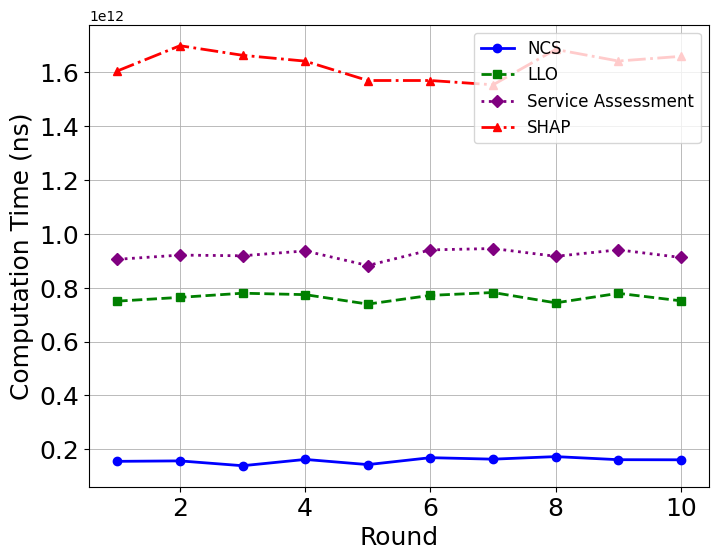

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Given lists for plotting (converted to nanoseconds)
NCS = [x * 1e9 for x in [155.2695, 156.9382, 138.9963, 162.3583, 143.1560, 168.8628, 163.3493, 172.8311, 161.4082, 160.9964]]
LLO = [x * 1e9 for x in [750.0, 764.0, 779.43, 774.15, 739.04, 771.40, 782.01, 743.61, 779.01, 751.13]]
SAM = [x * 1e9 for x in [905.2695, 920.9382, 918.4263, 936.5083, 882.196, 940.2628, 945.3593, 916.4411, 940.4182, 912.1264]]
SHAP = [x * 1e9 for x in [1604.60, 1698.23, 1662.69, 1641.02, 1569.09, 1569.09, 1553.18, 1684.49, 1641.42, 1658.80]]

# Define plot settings
plot_settings = {
    "FCS": {"color": "blue", "marker": "o", "linestyle": "-"},
    "QoS_CS": {"color": "green", "marker": "s", "linestyle": "--"},
    "Service Assessment": {"color": "purple", "marker": "D", "linestyle": ":"},
    "Shapley Value": {"color": "red", "marker": "^", "linestyle": "-."}
}

# Rounds (assuming 10 epochs)
rounds = np.arange(1, 11)

plt.figure(figsize=(8, 6))

# Plot each method with its own style settings
plt.plot(rounds, NCS , label="NCS", **plot_settings["FCS"], markersize=6, linewidth=2)
plt.plot(rounds, LLO, label="LLO", **plot_settings["QoS_CS"], markersize=6, linewidth=2)
plt.plot(rounds, SAM, label="Service Assessment", **plot_settings["Service Assessment"], markersize=6, linewidth=2)
plt.plot(rounds, SHAP, label="SHAP", **plot_settings["Shapley Value"], markersize=6, linewidth=2)

plt.xlabel("Round", fontsize=18)
plt.ylabel("Computation Time (ns)", fontsize=18)
plt.legend(fontsize=12, loc="upper right", bbox_to_anchor=(1, 1))
plt.grid(True, linewidth=0.6)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Display the updated plot in nanoseconds
plt.show()

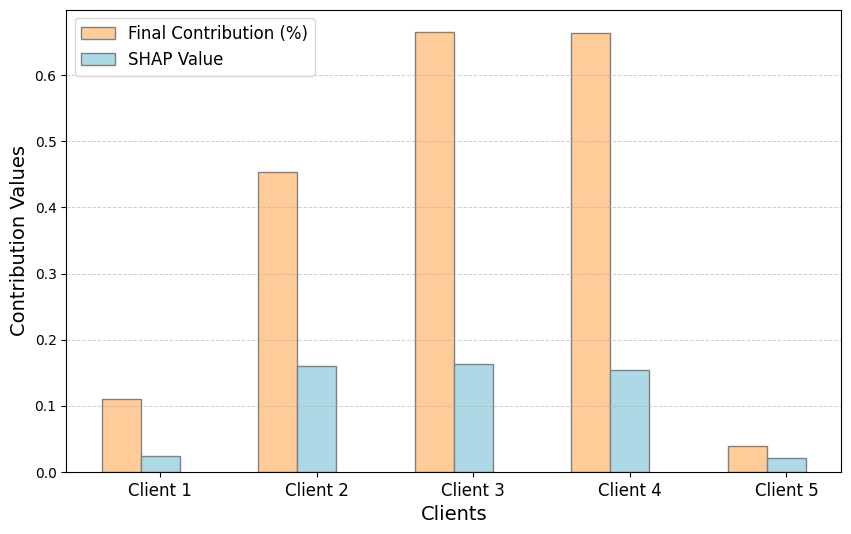

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Given data
clients = ["Client 1", "Client 2", "Client 3", "Client 4", "Client 5"]
final_contributions = [0.109391, 0.453038, 0.666029, 0.663499, 0.039294]
sharp_values = [0.0238, 0.1593, 0.1633, 0.1540, 0.0206]
ncs_values = [0.2, 0.18, 0.17, 0.15, 0.18]

# Bar width
bar_width = 0.25

# Set position for bars on X-axis
r1 = np.arange(len(clients))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Define light colors
light_blue = "#add8e6"  # Light blue
light_orange = "#ffcc99" # Light orange
light_green = "#90ee90" # Light green

# Create bar chart with light colors
plt.figure(figsize=(10, 6))
plt.bar(r1, final_contributions, color=light_orange, width=bar_width, edgecolor='grey', label='Final Contribution (%)')
plt.bar(r2, sharp_values, color=light_blue, width=bar_width, edgecolor='grey', label='SHAP Value')
#plt.bar(r3, ncs_values, color=light_green, width=bar_width, edgecolor='grey', label='NCS Value')

# Labels and title
plt.xlabel("Clients", fontsize=14)
plt.ylabel("Contribution Values", fontsize=14)
plt.xticks([r + bar_width for r in range(len(clients))], clients, fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

# Show plot
plt.show()